In [1]:
import os, json, collections

import sqlite3
from sqlite3 import Error
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt

# Meta Data Management

using sqlite3 to manage data

columns
['id', 'noise_ratio', 'v', 'alpha', 'dataset', 'model', 'num_epoch']


In [2]:
def connect(db_file="./meta-noise-ratio.db"):
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
    return None

In [6]:
def create_table():
    with connect() as conn:
        c = conn.cursor()
        c.execute(
            """
            CREATE TABLE IF NOT EXISTS tasks (
            id text PRIMARY KEY,
            task_id text NOT NULL,
            noise_ratio float NOT NULL,
            v float NOT NULL,
            alpha float NOT NULL,
            weight_decay float NOT NULL,
            dataset text NOT NULL,
            model text NOT NULL,
            num_epoch integer NOT NULL,
            path text NOT NULL
            );
            """
        )
        conn.commit()


In [5]:
def scan(log_dir='log'):
    with connect() as conn:
        c = conn.cursor()
        for dataset in os.listdir(log_dir):
            count = 0
            if dataset == ".DS_Store":
                continue
            dataset_dir = os.path.join(log_dir, dataset)
            for file in os.listdir(dataset_dir):
                tmp_record = {}
                if file.split('.')[-1] == 'meta':
                    fprefix = file[:-5]
                    if not os.path.exists(os.path.join(dataset_dir, fprefix + '.log')):
                        continue
                    with open(os.path.join(dataset_dir, 
                                           fprefix + '.meta'), 'rt') as f:
                        metainfo = json.load(f)
                    with open(os.path.join(dataset_dir,
                                           fprefix + '.log'), 'rt') as f:
                        df = pd.read_csv(f)
                    if len(df) < 50:
                        print("sequence too short", fprefix, len(df))
                        continue
                    info = (dataset_dir+fprefix,
                            metainfo['task_id'],
                            metainfo['noise_ratio'],
                            metainfo['v'],
                            metainfo['alpha'],
                            metainfo.get('weight_decay', 0),
                            metainfo['dataset'],
                            metainfo['model'],
                            len(df),
                            "{}/{}.log".format(dataset_dir, fprefix))
                    try:
                        c.execute(
                            """
                            INSERT INTO 
                            tasks(id, task_id, noise_ratio, v, alpha, weight_decay, dataset, model, num_epoch, path) 
                            VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                            """, info
                        )
                        count += 1
                    except Error as e:
                        pass
            print("new", dataset, count)
        conn.commit()

In [28]:
create_table()
scan()

sequence too short default-200102232932-1098-DNN 29
sequence too short default-200103170416--178-DNN 25
sequence too short wd-200203-145317d069-DNN 43
sequence too short default-200207-0006281780-DNNcase_name 0
sequence too short default-200202-212004b1fb-DNN 20
sequence too short default-200102233521-1143-DNN 21
sequence too short wd-200203-14531832a6-DNN 41
sequence too short default-200202-204704408c-CNN 20
sequence too short default-200102232330-7936-DNN 34
sequence too short plain-200203-1453188eb3-DNN 41
sequence too short default-200207-0007031780-DNNcase_name 0
sequence too short default-200103001240--783-DNN 17
sequence too short default-200211-100645faba-DNN 1
sequence too short default-200207-0014201780-DNNcase_name 15
sequence too short default-200103165052--785-DNN 21
sequence too short default-200207-001650202f-DNNcase_name 48
sequence too short default-200202-212002e89d-DNN 20
sequence too short default-200207-0010401780-DNNcase_name 13
sequence too short default-200202-

# Plots

## General Function

In [7]:
def plot_label_noise(selection_dict, iter_var, iter_var_name=None, iter_filter=None, ax=plt):
    sql = "SELECT {}, path FROM tasks WHERE ".format(iter_var)
    sql += " and ".join("{}={}".format(k, '"{}"'.format(v) if isinstance(v, str) else v) 
                        for k, v in selection_dict.items())
    sql += " ORDER BY {} ASC ".format(iter_var)
    print(sql)
    test_acc_dict = collections.defaultdict(list)
    with connect() as conn:
        c = conn.cursor()
        c.execute(sql)
        for iter_value, path in c.fetchall():
            df = pd.read_csv(path)
            df.columns = [c.strip() for c in df.columns]
            test_acc_dict[iter_value].append(np.asarray(df['test_acc']).reshape(1, -1))

    header = ["IterVar", "IterValue", "SubSeqLen", "Best", "AVE"]
    records = []
            
    for iter_value, seq_list in test_acc_dict.items():
        if iter_filter:
            if not iter_filter(iter_value):
                continue
        if len(seq_list) > 1:
            cseq = np.concatenate(seq_list, 0)
            ave = cseq.mean(0)
            err = cseq.std(0)
        else:
            seq = seq_list[0]
            ave = np.asarray([np.mean(seq[0, max(0, i-1): min(len(seq[0]), i+1)]) for i in range(len(seq[0]))])
            err = np.asarray([np.std( seq[0, max(0, i-1): min(len(seq[0]), i+1)]) for i in range(len(seq[0]))])
        x = np.arange(len(ave))
        ax.plot(x, ave, label='{}={}'.format(iter_var_name, iter_value))
        ax.fill_between(x, ave-err, ave+err, alpha=0.2)        
        records.append((iter_var, iter_value, len(seq_list), np.max(ave), np.mean(ave[-10:])))

    print(tabulate(records, headers=header))


In [23]:
def gather_label_noise_case(selection_dict, visual=False):
    sql = "SELECT path FROM tasks WHERE "
    sql += " and ".join("{}={}".format(k, '"{}"'.format(v) if isinstance(v, str) else v) 
                        for k, v in selection_dict.items())
#     sql += " ORDER BY {} ASC ".format(iter_var)
#     print(sql)
    seq_list = []
    path_list = []
    with connect() as conn:
        c = conn.cursor()
        c.execute(sql)
        for path, *_ in c.fetchall():
#             print(path)
            df = pd.read_csv(path)
            df.columns = [c.strip() for c in df.columns]
            seq = np.asarray(df['test_acc']).reshape(-1)
            if len(seq) == 100:
                seq_list.append(seq)
                path_list.append(path)
    if visual:
        plt.figure(figsize=(10, 10))
        for s, p in zip(seq_list, path_list):
            print(p, len(s))
            plt.plot(np.arange(len(s)), s, label=p)
        plt.legend()
        plt.show()
    best = np.mean([np.max(s) for s in seq_list])
    last = np.mean([np.mean(s[-10:]) for s in seq_list])
    return best, last

# Grid Search

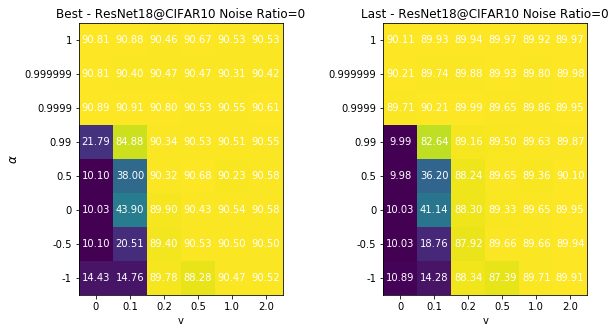

In [13]:
# vlist = sorted([0.1, 0.2, 0.25, 0.5, 1.0, 2.0])
vlist = sorted([0, 0.1, 0.2, 0.5, 1.0, 2.0])
alist = sorted([1, 0.999999, 0.9999, 0.99, 0.5, 0, -0.5, -1])

best_mat = []
last_mat = []

for alpha in alist:
    best_v = []
    last_v = []
    for v in vlist:
        selection_dict = {"noise_ratio": 0,
                          "v": v,
                          "alpha": alpha,
                          "task_id": "forpub",
                          "weight_decay": 0,
                          "model": "ResNet18",
                          "dataset": "CIFAR10"}
        best, last = gather_label_noise_case(selection_dict)
        best_v.append(best)
        last_v.append(last)
    best_mat.append(best_v)
    last_mat.append(last_v)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(best_mat)
ax1.set_xticks(np.arange(len(vlist)))
ax1.set_xticklabels(vlist)
ax1.set_yticks(np.arange(len(alist)))
ax1.set_yticklabels(alist)
ax1.set_ylim([-0.5, len(alist)-0.5])
for i in range(len(alist)):
    for j in range(len(vlist)):
        text = ax1.text(j, i, "{:.2f}".format(best_mat[i][j]),
                       ha="center", va="center", color="w")
ax1.set_title("Best - ResNet18@CIFAR10 Noise Ratio=0", fontsize=12)
ax1.set_ylabel(r"$\alpha$", fontsize=12)
ax1.set_xlabel("v")

ax2.imshow(last_mat)
ax2.set_xticks(np.arange(len(vlist)))
ax2.set_xticklabels(vlist)
ax2.set_yticks(np.arange(len(alist)))
ax2.set_yticklabels(alist)
ax2.set_ylim([-0.5, len(alist)-0.5])
for i in range(len(alist)):
    for j in range(len(vlist)):
        text = ax2.text(j, i, "{:.2f}".format(last_mat[i][j]),
                       ha="center", va="center", color="w")
ax2.set_title("Last - ResNet18@CIFAR10 Noise Ratio=0", fontsize=12)
ax2.set_xlabel("v")
plt.show()

In [55]:
with connect() as conn:
    c = conn.cursor()
    c.execute("SELECT v, alpha, path FROM tasks WHERE v = 0 and noise_ratio=0 and task_id='forpub'")
    for record in c.fetchall():
        print(record)

(0.0, 0.99, 'log/CIFAR10/forpub-200216-192234627e-ResNet18.log')
(0.0, -0.5, 'log/CIFAR10/forpub-200216-23564380a3-ResNet18.log')
(0.0, 0.5, 'log/CIFAR10/forpub-200216-204935e65d-ResNet18.log')
(0.0, -1.0, 'log/CIFAR10/forpub-200217-012849dbb3-ResNet18.log')
(0.0, 0.0, 'log/CIFAR10/forpub-200216-222128d449-ResNet18.log')
(0.0, 0.999999, 'log/CIFAR10/forpub-200216-161449eccd-ResNet18.log')
(0.0, 1.0, 'log/CIFAR10/forpub-200216-1509008fe1-ResNet18.log')
(0.0, 0.9999, 'log/CIFAR10/forpub-200216-1749471878-ResNet18.log')


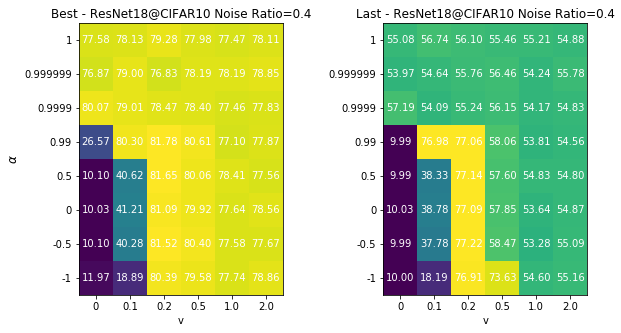

In [56]:
vlist = sorted([0, 0.1, 0.2, 0.5, 1.0, 2.0])
alist = sorted([1, 0.999999, 0.9999, 0.99, 0.5, 0, -0.5, -1])

best_mat = []
last_mat = []

for alpha in alist:
    best_v = []
    last_v = []
    for v in vlist:
        selection_dict = {"noise_ratio": 0.4,
                          "v": v,
                          "alpha": alpha,
                          "weight_decay": 0,
                          "model": "ResNet18",
                          "dataset": "CIFAR10"}
        best, last = gather_label_noise_case(selection_dict)
        best_v.append(best)
        last_v.append(last)
    best_mat.append(best_v)
    last_mat.append(last_v)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(best_mat)
ax1.set_xticks(np.arange(len(vlist)))
ax1.set_xticklabels(vlist)
ax1.set_yticks(np.arange(len(alist)))
ax1.set_yticklabels(alist)
ax1.set_ylim([-0.5, len(alist)-0.5])
for i in range(len(alist)):
    for j in range(len(vlist)):
        text = ax1.text(j, i, "{:.2f}".format(best_mat[i][j]),
                       ha="center", va="center", color="w")
ax1.set_title("Best - ResNet18@CIFAR10 Noise Ratio=0.4", fontsize=12)
ax1.set_ylabel(r"$\alpha$", fontsize=12)
ax1.set_xlabel("v")

ax2.imshow(last_mat)
ax2.set_xticks(np.arange(len(vlist)))
ax2.set_xticklabels(vlist)
ax2.set_yticks(np.arange(len(alist)))
ax2.set_yticklabels(alist)
ax2.set_ylim([-0.5, len(alist)-0.5])
for i in range(len(alist)):
    for j in range(len(vlist)):
        text = ax2.text(j, i, "{:.2f}".format(last_mat[i][j]),
                       ha="center", va="center", color="w")
ax2.set_title("Last - ResNet18@CIFAR10 Noise Ratio=0.4", fontsize=12)
ax2.set_xlabel("v")
plt.show()

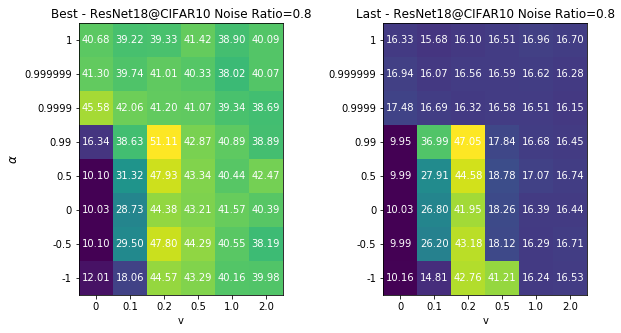

In [60]:
vlist = sorted([0, 0.1, 0.2, 0.5, 1.0, 2.0])
alist = sorted([1, 0.999999, 0.9999, 0.99, 0.5, 0, -0.5, -1])

best_mat = []
last_mat = []

for alpha in alist:
    best_v = []
    last_v = []
    for v in vlist:
        selection_dict = {"noise_ratio": 0.8,
                          "v": v,
                          "alpha": alpha,
                          "weight_decay": 0,
                          "model": "ResNet18",
                          "dataset": "CIFAR10"}
        best, last = gather_label_noise_case(selection_dict)
        best_v.append(best)
        last_v.append(last)
    best_mat.append(best_v)
    last_mat.append(last_v)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(best_mat)
ax1.set_xticks(np.arange(len(vlist)))
ax1.set_xticklabels(vlist)
ax1.set_yticks(np.arange(len(alist)))
ax1.set_yticklabels(alist)
ax1.set_ylim([-0.5, len(alist)-0.5])
for i in range(len(alist)):
    for j in range(len(vlist)):
        text = ax1.text(j, i, "{:.2f}".format(best_mat[i][j]),
                       ha="center", va="center", color="w")
ax1.set_title("Best - ResNet18@CIFAR10 Noise Ratio=0.8", fontsize=12)
ax1.set_ylabel(r"$\alpha$", fontsize=12)
ax1.set_xlabel("v")

ax2.imshow(last_mat)
ax2.set_xticks(np.arange(len(vlist)))
ax2.set_xticklabels(vlist)
ax2.set_yticks(np.arange(len(alist)))
ax2.set_yticklabels(alist)
ax2.set_ylim([-0.5, len(alist)-0.5])
for i in range(len(alist)):
    for j in range(len(vlist)):
        text = ax2.text(j, i, "{:.2f}".format(last_mat[i][j]),
                       ha="center", va="center", color="w")
ax2.set_title("Last - ResNet18@CIFAR10 Noise Ratio=0.8", fontsize=12)
ax2.set_xlabel("v")
plt.show()

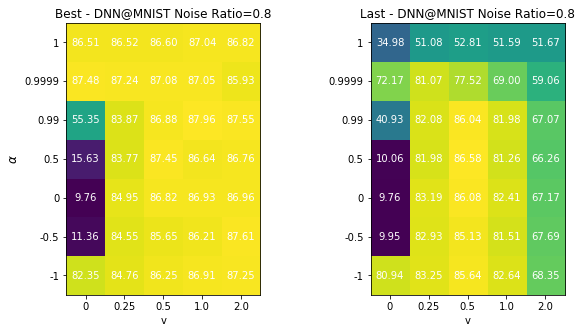

In [26]:
# vlist = sorted([0.1, 0.2, 0.25, 0.5, 1.0, 2.0])
vlist = sorted([0, 0.25, 0.5, 1.0, 2.0])
alist = sorted([1, 0.9999, 0.99, 0.5, 0, -0.5, -1])

best_mat = []
last_mat = []

for alpha in alist:
    best_v = []
    last_v = []
    for v in vlist:
        selection_dict = {"noise_ratio": 0.8,
                          "v": v,
                          "task_id": "forpub",
                          "alpha": alpha,
                          "weight_decay": 0,
                          "model": "DNN",
                          "dataset": "MNIST"}
        best, last = gather_label_noise_case(selection_dict)
        best_v.append(best)
        last_v.append(last)
    best_mat.append(best_v)
    last_mat.append(last_v)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(best_mat)
ax1.set_xticks(np.arange(len(vlist)))
ax1.set_xticklabels(vlist)
ax1.set_yticks(np.arange(len(alist)))
ax1.set_yticklabels(alist)
ax1.set_ylim([-0.5, len(alist)-0.5])
for i in range(len(alist)):
    for j in range(len(vlist)):
        text = ax1.text(j, i, "{:.2f}".format(best_mat[i][j]),
                       ha="center", va="center", color="w")
ax1.set_title("Best - DNN@MNIST Noise Ratio=0.8", fontsize=12)
ax1.set_ylabel(r"$\alpha$", fontsize=12)
ax1.set_xlabel("v")

ax2.imshow(last_mat)
ax2.set_xticks(np.arange(len(vlist)))
ax2.set_xticklabels(vlist)
ax2.set_yticks(np.arange(len(alist)))
ax2.set_yticklabels(alist)
ax2.set_ylim([-0.5, len(alist)-0.5])
for i in range(len(alist)):
    for j in range(len(vlist)):
        text = ax2.text(j, i, "{:.2f}".format(last_mat[i][j]),
                       ha="center", va="center", color="w")
ax2.set_title("Last - DNN@MNIST Noise Ratio=0.8", fontsize=12)
ax2.set_xlabel("v")
plt.show()

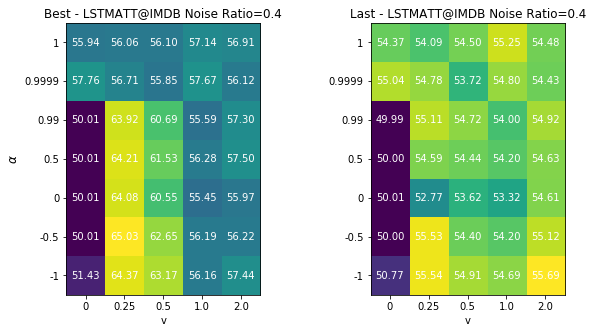

In [29]:
# vlist = sorted([0.1, 0.2, 0.25, 0.5, 1.0, 2.0])
vlist = sorted([0, 0.25, 0.5, 1.0, 2.0])
alist = sorted([1, 0.9999, 0.99, 0.5, 0, -0.5, -1])

best_mat = []
last_mat = []

for alpha in alist:
    best_v = []
    last_v = []
    for v in vlist:
        selection_dict = {"noise_ratio": 0.4,
                          "v": v,
                          "alpha": alpha,
                          "weight_decay": 0,
                          "model": "LSTMATT",
                          "dataset": "IMDB"}
        best, last = gather_label_noise_case(selection_dict)
        best_v.append(best)
        last_v.append(last)
    best_mat.append(best_v)
    last_mat.append(last_v)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(best_mat)
ax1.set_xticks(np.arange(len(vlist)))
ax1.set_xticklabels(vlist)
ax1.set_yticks(np.arange(len(alist)))
ax1.set_yticklabels(alist)
ax1.set_ylim([-0.5, len(alist)-0.5])
for i in range(len(alist)):
    for j in range(len(vlist)):
        text = ax1.text(j, i, "{:.2f}".format(best_mat[i][j]),
                       ha="center", va="center", color="w")
ax1.set_title("Best - LSTMATT@IMDB Noise Ratio=0.4", fontsize=12)
ax1.set_ylabel(r"$\alpha$", fontsize=12)
ax1.set_xlabel("v")

ax2.imshow(last_mat)
ax2.set_xticks(np.arange(len(vlist)))
ax2.set_xticklabels(vlist)
ax2.set_yticks(np.arange(len(alist)))
ax2.set_yticklabels(alist)
ax2.set_ylim([-0.5, len(alist)-0.5])
for i in range(len(alist)):
    for j in range(len(vlist)):
        text = ax2.text(j, i, "{:.2f}".format(last_mat[i][j]),
                       ha="center", va="center", color="w")
ax2.set_title("Last - LSTMATT@IMDB Noise Ratio=0.4", fontsize=12)
ax2.set_xlabel("v")
plt.show()

## Snippet

SELECT alpha, path FROM tasks WHERE noise_ratio=0.4 and v=0.5 and weight_decay=0 and model="LSTMATT" and dataset="IMDB" ORDER BY alpha ASC 
IterVar      IterValue    SubSeqLen     Best      AVE
---------  -----------  -----------  -------  -------
alpha          -1                 3  62.8351  54.9141
alpha          -0.5               2  61.6287  54.4045
alpha           0                 2  59.0214  53.6204
alpha           0.5               3  61.068   54.4399
alpha           0.99              2  60.6936  54.718
alpha           0.9999            2  55.7402  53.7246
alpha           1                 3  55.5344  54.4974


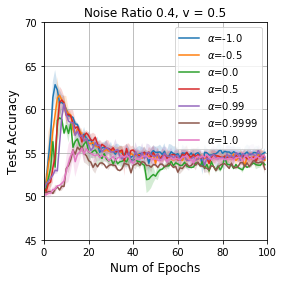

In [15]:
selection_dict = {"noise_ratio": 0.4,
                  "v":0.5,
                  "weight_decay": 0,
                  "model": "LSTMATT",
                  "dataset": "IMDB"}

iter_var='alpha'
iter_var_name=r'$\alpha$'

plt.figure(figsize=(4,4))
plot_label_noise(selection_dict, iter_var, iter_var_name)
plt.legend()
plt.title(r"Noise Ratio 0.4, v = 0.5", fontsize=12)
plt.xlabel("Num of Epochs", fontsize=12)
plt.ylabel("Test Accuracy", fontsize=12)
plt.xlim([0, 100])
plt.ylim([45, 70])
plt.grid()
plt.show()

# IMDB

SELECT alpha, path FROM tasks WHERE noise_ratio=0.4 and v=0.5 and weight_decay=0 and model="LSTMATT" and dataset="IMDB" ORDER BY alpha ASC 
IterVar      IterValue    SubSeqLen     Best      AVE
---------  -----------  -----------  -------  -------
alpha          -1                 3  62.8351  54.9141
alpha          -0.5               2  61.6287  54.4045
alpha           0                 2  59.0214  53.6204
alpha           0.5               3  61.068   54.4399
alpha           0.99              2  60.6936  54.718
alpha           0.9999            2  55.7402  53.7246
alpha           1                 3  55.5344  54.4974


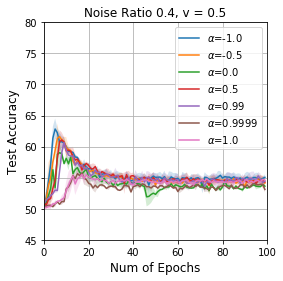

In [16]:
selection_dict = {"noise_ratio": 0.4,
                  "v":0.5,
                  "weight_decay": 0,
                  "model": "LSTMATT",
                  "dataset": "IMDB"}

iter_var='alpha'
iter_var_name=r'$\alpha$'

plt.figure(figsize=(4,4))
plot_label_noise(selection_dict, iter_var, iter_var_name)
plt.legend()
plt.title(r"Noise Ratio 0.4, v = 0.5", fontsize=12)
plt.xlabel("Num of Epochs", fontsize=12)
plt.ylabel("Test Accuracy", fontsize=12)
plt.xlim([0, 100])
plt.ylim([45, 80])
plt.grid()
plt.show()

SELECT v, path FROM tasks WHERE noise_ratio=0.4 and alpha=0.5 and weight_decay=0 and model="LSTMATT" and dataset="IMDB" ORDER BY v ASC 
IterVar      IterValue    SubSeqLen     Best      AVE
---------  -----------  -----------  -------  -------
v                 0.25            3  63.6139  54.5856
v                 0.5             3  61.068   54.4399
v                 1               3  55.6712  54.2015
v                 2               3  57.0607  54.63


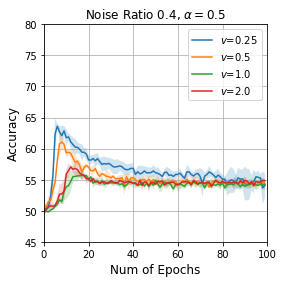

In [17]:
selection_dict = {"noise_ratio": 0.4, 
                  "alpha":0.5,
                  "weight_decay": 0,
                  "model": "LSTMATT",
                  "dataset": "IMDB"}
iter_var='v'
iter_var_name=r'$v$'

plt.figure(figsize=(4,4))
plot_label_noise(selection_dict, iter_var, iter_var_name, iter_filter=lambda x: x<4)
plt.legend()
plt.title(r"Noise Ratio 0.4, $\alpha=0.5$", fontsize=12)
plt.xlabel("Num of Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xlim([0, 100])
plt.ylim([45, 80])
plt.grid()
plt.show()

SELECT alpha, path FROM tasks WHERE noise_ratio=0.2 and v=0.5 and weight_decay=0 and model="LSTMATT" and dataset="IMDB" ORDER BY alpha ASC 
IterVar      IterValue    SubSeqLen     Best      AVE
---------  -----------  -----------  -------  -------
alpha          -1                 1  69.5392  59.9776
alpha          -0.5               1  72.4857  65.1718
alpha           0                 1  73.1916  66.2325
alpha           0.5               2  73.5627  65.1328
alpha           0.99              1  72.2903  64.7294
alpha           0.9999            1  70.515   65.3195
alpha           1                 2  71.0212  65.3748


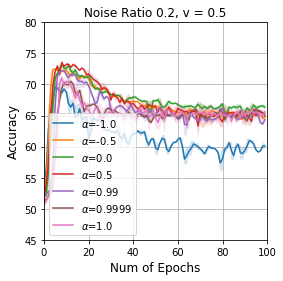

In [18]:
selection_dict = {"noise_ratio": 0.2, 
                  "v":0.5,
                  "weight_decay": 0,
                  "model": "LSTMATT",
                  "dataset": "IMDB"}
iter_var='alpha'
iter_var_name=r'$\alpha$'

plt.figure(figsize=(4,4))
plot_label_noise(selection_dict, iter_var, iter_var_name)
plt.legend()
plt.title(r"Noise Ratio 0.2, v = 0.5", fontsize=12)
plt.xlabel("Num of Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xlim([0, 100])
plt.ylim([45, 80])
plt.grid()
plt.show()

SELECT v, path FROM tasks WHERE noise_ratio=0.2 and alpha=0.5 and weight_decay=0 and model="LSTMATT" and dataset="IMDB" ORDER BY v ASC 
IterVar      IterValue    SubSeqLen     Best      AVE
---------  -----------  -----------  -------  -------
v                 0.25            3  72.8617  64.5415
v                 0.5             2  73.5627  65.1328
v                 1               2  71.3811  65.4366
v                 2               2  71.3608  66.7506


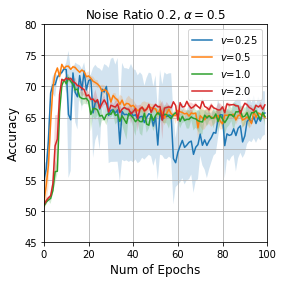

In [19]:
selection_dict = {"noise_ratio": 0.2, 
                  "alpha":0.5,
                  "weight_decay": 0,
                  "model": "LSTMATT",
                  "dataset": "IMDB"}
iter_var='v'
iter_var_name=r'$v$'

plt.figure(figsize=(4,4))
plot_label_noise(selection_dict, iter_var, iter_var_name, iter_filter=lambda x: x<4)
plt.legend()
plt.title(r"Noise Ratio 0.2, $\alpha=0.5$", fontsize=12)
plt.xlabel("Num of Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xlim([0, 100])
plt.ylim([45, 80])
plt.grid()
plt.show()

## CIFAR 10

SELECT alpha, path FROM tasks WHERE noise_ratio=0.4 and v=0.25 and weight_decay=0 and model="ResNet18" and dataset="CIFAR10" ORDER BY alpha ASC 
IterVar      IterValue    SubSeqLen     Best      AVE
---------  -----------  -----------  -------  -------
alpha          -1                 5  78.7144  77.464
alpha          -0.5               2  80.1473  72.4955
alpha           0                 2  80.894   74.329
alpha           0.5               1  79.9496  71.9625
alpha           0.99              1  80.9484  72.2785
alpha           0.9999            1  78.8271  56.0156
alpha           1                 1  77.6701  56.1921


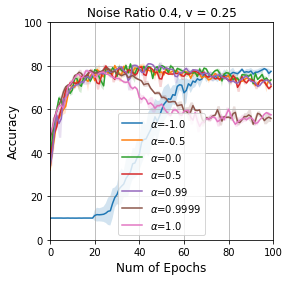

In [20]:
selection_dict = {"noise_ratio": 0.4,
                  "v":0.25,
                  "weight_decay": 0,
                  "model": "ResNet18",
                  "dataset": "CIFAR10"}

iter_var='alpha'
iter_var_name=r'$\alpha$'

plt.figure(figsize=(4,4))
plot_label_noise(selection_dict, iter_var, iter_var_name)
plt.legend()
plt.title(r"Noise Ratio 0.4, v = 0.25", fontsize=12)
plt.xlabel("Num of Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xlim([0, 100])
plt.ylim([0, 100])
plt.grid()
plt.show()

SELECT v, path FROM tasks WHERE noise_ratio=0.4 and alpha=-1 and weight_decay=0 and model="ResNet18" and dataset="CIFAR10" ORDER BY v ASC 
IterVar      IterValue    SubSeqLen     Best      AVE
---------  -----------  -----------  -------  -------
v                 0.25            5  78.7144  77.464
v                 0.5             2  78.9062  73.9527
v                 1               2  77.6652  54.2989
v                 2               2  78.6491  55.8895


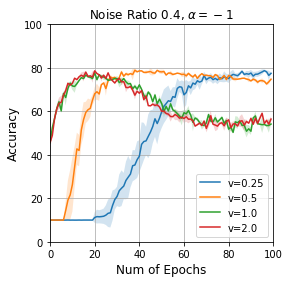

In [21]:
selection_dict = {"noise_ratio": 0.4,
                  "alpha":-1,
                  "weight_decay": 0,
                  "model": "ResNet18",
                  "dataset": "CIFAR10"}

iter_var='v'
iter_var_name=r'v'

plt.figure(figsize=(4,4))
plot_label_noise(selection_dict, iter_var, iter_var_name)
plt.legend()
plt.title(r"Noise Ratio 0.4, $\alpha=-1$", fontsize=12)
plt.xlabel("Num of Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xlim([0, 100])
plt.ylim([0, 100])
plt.grid()
plt.show()

SELECT alpha, path FROM tasks WHERE noise_ratio=0.8 and v=0.25 and weight_decay=0 and model="ResNet18" and dataset="CIFAR10" ORDER BY alpha ASC 
IterVar      IterValue    SubSeqLen     Best      AVE
---------  -----------  -----------  -------  -------
alpha          -1                 4  25.1879  24.2415
alpha          -0.5               3  43.6907  41.0071
alpha           0                 3  44.5675  40.3745
alpha           0.5               4  44.645   39.4843
alpha           0.99              2  44.8378  35.5291
alpha           0.9999            2  42.2122  16.782
alpha           1                 2  38.7164  16.7029


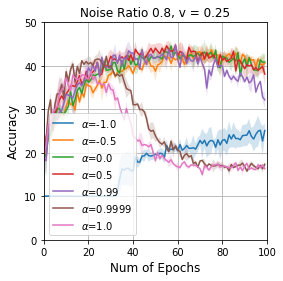

In [22]:
selection_dict = {"noise_ratio": 0.8,
                  "v":0.25,
                  "weight_decay": 0,
                  "model": "ResNet18",
                  "dataset": "CIFAR10"}

iter_var='alpha'
iter_var_name=r'$\alpha$'

plt.figure(figsize=(4,4))
plot_label_noise(selection_dict, iter_var, iter_var_name)
plt.legend()
plt.title(r"Noise Ratio 0.8, v = 0.25", fontsize=12)
plt.xlabel("Num of Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xlim([0, 100])
plt.ylim([0, 50])
plt.grid()
plt.show()

SELECT v, path FROM tasks WHERE noise_ratio=0.8 and alpha=0.5 and weight_decay=0 and model="ResNet18" and dataset="CIFAR10" ORDER BY v ASC 
IterVar      IterValue    SubSeqLen     Best      AVE
---------  -----------  -----------  -------  -------
v                 0.15            3  40.0481  38.3703
v                 0.2             3  44.0038  42.0517
v                 0.25            4  44.645   39.4843
v                 0.5             3  42.7874  18.5845
v                 1               3  39.0625  16.9663
v                 2               2  39.7992  16.7296


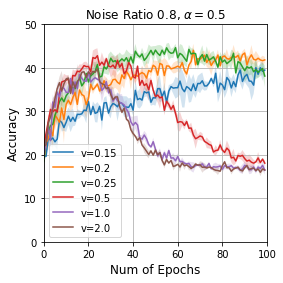

In [23]:
selection_dict = {"noise_ratio": 0.8,
                  "alpha":0.5,
                  "weight_decay": 0,
                  "model": "ResNet18",
                  "dataset": "CIFAR10"}

iter_var='v'
iter_var_name=r'v'

plt.figure(figsize=(4,4))
plot_label_noise(selection_dict, iter_var, iter_var_name)
plt.legend()
plt.title(r"Noise Ratio 0.8, $\alpha=0.5$", fontsize=12)
plt.xlabel("Num of Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xlim([0, 100])
plt.ylim([0, 50])
plt.grid()
plt.show()

# MNIST

SELECT alpha, path FROM tasks WHERE noise_ratio=0.4 and v=0.5 and weight_decay=0 and model="DNN" and dataset="MNIST" ORDER BY alpha ASC 
IterVar      IterValue    SubSeqLen     Best      AVE
---------  -----------  -----------  -------  -------
alpha          -1                 1  89.3888  89.2054
alpha          -0.5               1  89.1367  89.0477
alpha           0                 1  89.2356  89.1208
alpha           0.5               1  89.2257  89.0289
alpha           0.99              1  90.0069  89.8363
alpha           0.9999            1  96.0344  95.9365
alpha           1                 1  96.0344  94.8042


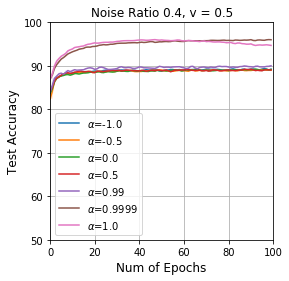

In [24]:
selection_dict = {"noise_ratio": 0.4,
                  "v":0.5,
                  "weight_decay": 0,
                  "model": "DNN",
                  "dataset": "MNIST"}

iter_var='alpha'
iter_var_name=r'$\alpha$'

plt.figure(figsize=(4,4))
plot_label_noise(selection_dict, iter_var, iter_var_name)
plt.legend()
plt.title(r"Noise Ratio 0.4, v = 0.5", fontsize=12)
plt.xlabel("Num of Epochs", fontsize=12)
plt.ylabel("Test Accuracy", fontsize=12)
plt.xlim([0, 100])
plt.ylim([50, 100])
plt.grid()
plt.show()

SELECT v, path FROM tasks WHERE noise_ratio=0.4 and alpha=0.99 and weight_decay=0 and model="DNN" and dataset="MNIST" ORDER BY v ASC 
IterVar      IterValue    SubSeqLen     Best      AVE
---------  -----------  -----------  -------  -------
v                 0.25            1  84.6025  83.792
v                 0.5             1  90.0069  89.8363
v                 1               1  95.0801  94.9446
v                 2               1  96.0591  95.9588
v                 4               1  95.9553  95.1325


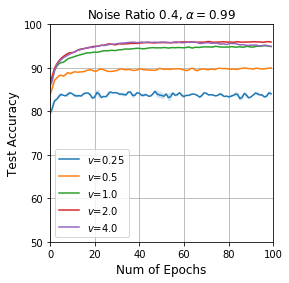

In [25]:
selection_dict = {"noise_ratio": 0.4,
                  "alpha":0.99,
                  "weight_decay": 0,
                  "model": "DNN",
                  "dataset": "MNIST"}

iter_var='v'
iter_var_name=r'$v$'

plt.figure(figsize=(4,4))
plot_label_noise(selection_dict, iter_var, iter_var_name)
plt.legend()
plt.title(r"Noise Ratio 0.4, $\alpha=0.99$", fontsize=12)
plt.xlabel("Num of Epochs", fontsize=12)
plt.ylabel("Test Accuracy", fontsize=12)
plt.xlim([0, 100])
plt.ylim([50, 100])
plt.grid()
plt.show()

SELECT alpha, path FROM tasks WHERE noise_ratio=0.8 and v=0.5 and weight_decay=0 and model="DNN" and dataset="MNIST" ORDER BY alpha ASC 
IterVar      IterValue    SubSeqLen     Best      AVE
---------  -----------  -----------  -------  -------
alpha          -1                 1  86.0314  85.712
alpha          -0.5               1  85.5024  85.1454
alpha           0                 1  86.5358  86.0819
alpha           0.5               1  87.1786  86.5759
alpha           0.99              1  86.6297  86.07
alpha           0.9999            1  86.8127  77.5766
alpha           1                 1  86.5358  52.858


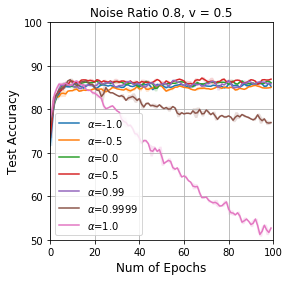

In [26]:
selection_dict = {"noise_ratio": 0.8,
                  "v":0.5,
                  "weight_decay": 0,
                  "model": "DNN",
                  "dataset": "MNIST"}

iter_var='alpha'
iter_var_name=r'$\alpha$'

plt.figure(figsize=(4,4))
plot_label_noise(selection_dict, iter_var, iter_var_name)
plt.legend()
plt.title(r"Noise Ratio 0.8, v = 0.5", fontsize=12)
plt.xlabel("Num of Epochs", fontsize=12)
plt.ylabel("Test Accuracy", fontsize=12)
plt.xlim([0, 100])
plt.ylim([50, 100])
plt.grid()
plt.show()

SELECT v, path FROM tasks WHERE noise_ratio=0.8 and alpha=0.99 and weight_decay=0 and model="DNN" and dataset="MNIST" ORDER BY v ASC 
IterVar      IterValue    SubSeqLen     Best      AVE
---------  -----------  -----------  -------  -------
v                 0.25            1  83.2723  82.1371
v                 0.5             1  86.6297  86.07
v                 1               1  87.7571  81.9289
v                 2               1  87.3121  67.2592
v                 4               1  85.5024  53.6803


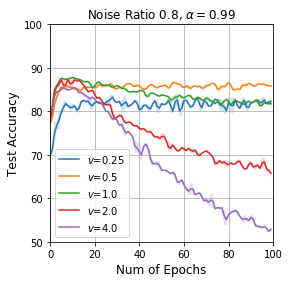

In [27]:
selection_dict = {"noise_ratio": 0.8,
                  "alpha":0.99,
                  "weight_decay": 0,
                  "model": "DNN",
                  "dataset": "MNIST"}

iter_var='v'
iter_var_name=r'$v$'

plt.figure(figsize=(4,4))
plot_label_noise(selection_dict, iter_var, iter_var_name)
plt.legend()
plt.title(r"Noise Ratio 0.8, $\alpha=0.99$", fontsize=12)
plt.xlabel("Num of Epochs", fontsize=12)
plt.ylabel("Test Accuracy", fontsize=12)
plt.xlim([0, 100])
plt.ylim([50, 100])
plt.grid()
plt.show()

In [6]:
from models import get_model

In [2]:
import torch

In [22]:
def plot_ResNet18_dist(mname1, mname2, name):
    model1 = get_model("ResNet18")
    model1.load_state_dict(torch.load(mname1))
    model2 = get_model("ResNet18")
    model2.load_state_dict(torch.load(mname2))
    i = 0
    for m1, m2 in zip(model1.modules(), model2.modules()):
        if isinstance(m1, torch.nn.Conv2d):
            i += 1
            w1 = m1.weight.data.detach().numpy()
            w2 = m2.weight.data.detach().numpy()
            up = max(np.max(w1), np.max(w2))
            down = min(np.min(w1), np.min(w2))
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,2))
            ax1.hist(w1.ravel(), bins=256)
            ax1.set_title("No. {} {}".format(i, m1))
            ax1.set_xlabel("weights", fontsize=16)
            ax1.set_ylabel("Counts", fontsize=16)
            ax1.set_xlim([down, up])
            ax2.hist(w2.ravel(), bins=256)
            ax2.set_title("No. {} {}".format(i, m2))
            ax2.set_xlabel("weights", fontsize=16)
            ax2.set_ylabel("Counts", fontsize=16)
            ax2.set_xlim([down, up])
            fig.tight_layout()
            fig.savefig("{}{}conv".format(name, i))

    for m1, m2 in zip(model1.modules(), model2.modules()):
        if isinstance(m1, torch.nn.Linear):
            w1 = m1.weight.data.detach().numpy()
            w2 = m2.weight.data.detach().numpy()
            up = max(np.max(w1), np.max(w2))
            down = min(np.min(w1), np.min(w2))
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,2))
            ax1.hist(w1.ravel(), bins=256)
            ax1.set_title(str(m1))
            ax1.set_xlabel("weights", fontsize=16)
            ax1.set_ylabel("Counts", fontsize=16)
            ax1.set_xlim([down, up])
            ax2.hist(w2.ravel(), bins=256)
            ax2.set_title(str(m2))
            ax2.set_xlabel("weights", fontsize=16)
            ax2.set_ylabel("Counts", fontsize=16)
            ax2.set_xlim([down, up])
            fig.tight_layout()
            fig.savefig("{}last_layer_weight".format(name))

    for m1, m2 in zip(model1.modules(), model2.modules()):
        if isinstance(m1, torch.nn.Linear):
            w1 = m1.bias.data.detach().numpy()
            w2 = m2.bias.data.detach().numpy()
            up = max(np.max(w1), np.max(w2))
            down = min(np.min(w1), np.min(w2))
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,2))
            ax1.hist(w1.ravel(), bins=10)
            ax1.set_title(str(m1))
            ax1.set_xlabel("bias", fontsize=16)
            ax1.set_ylabel("Counts", fontsize=16)
            ax1.set_xlim([down, up])
            ax2.hist(w2.ravel(), bins=10)
            ax2.set_title(str(m2))
            ax2.set_xlabel("bias", fontsize=16)
            ax2.set_ylabel("Counts", fontsize=16)
            ax2.set_xlim([down, up])
            fig.tight_layout()
            fig.savefig("{}last_layer_bias".format(name))

/Users/zihao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/zihao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


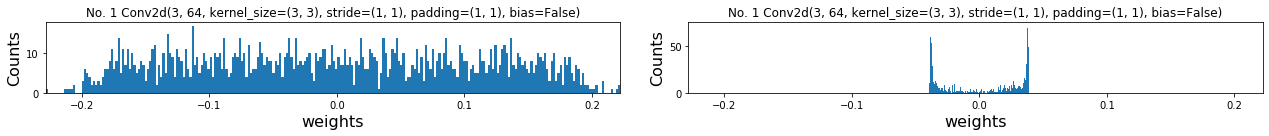

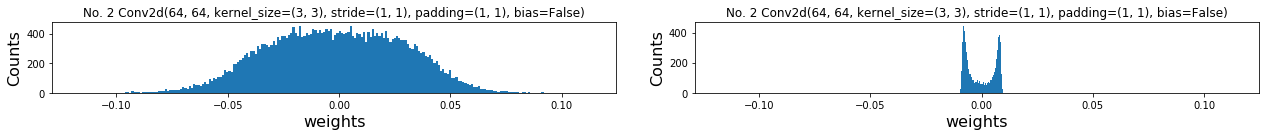

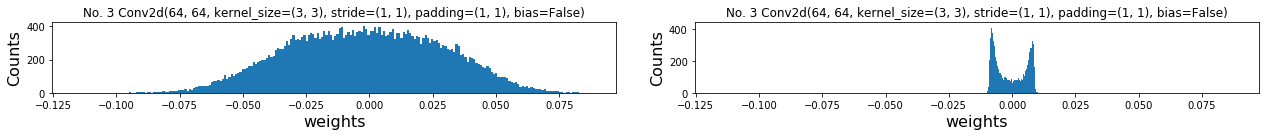

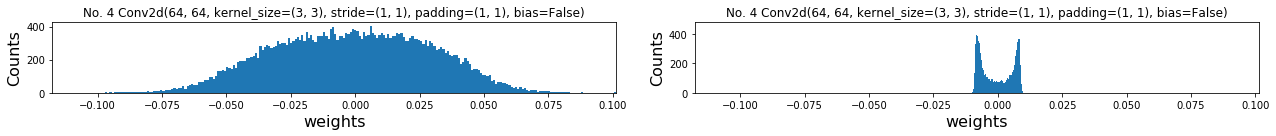

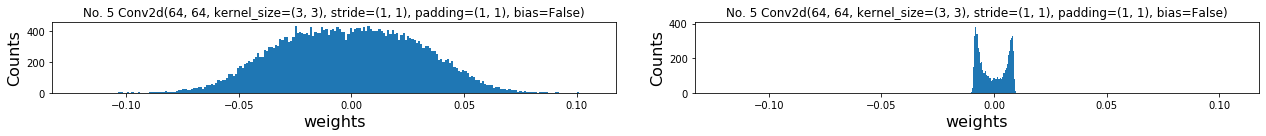

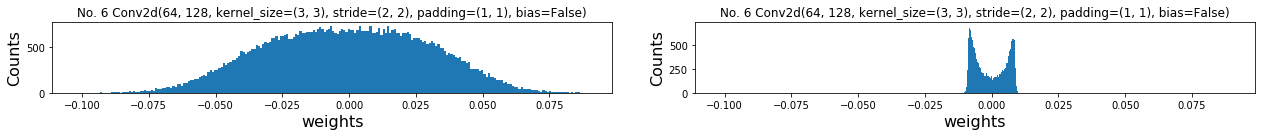

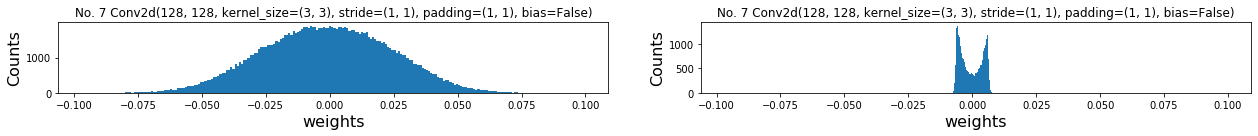

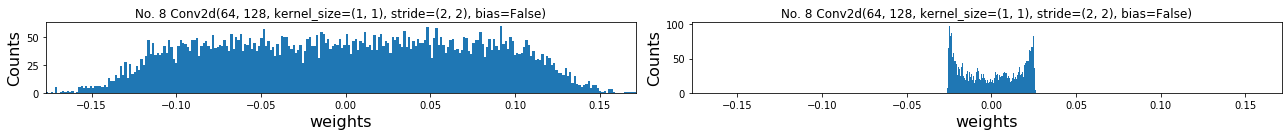

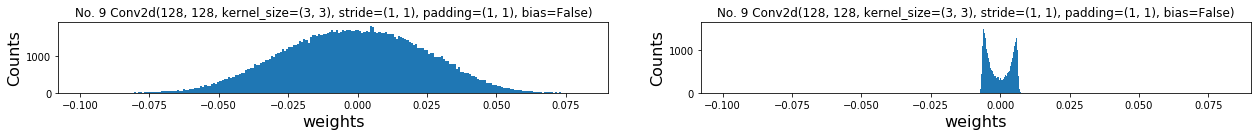

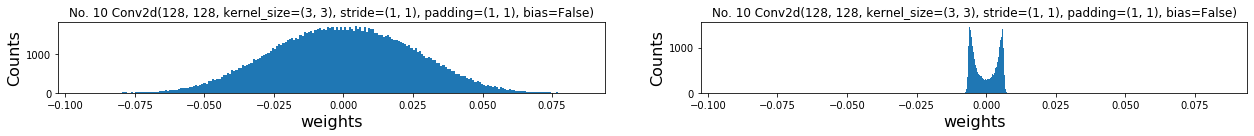

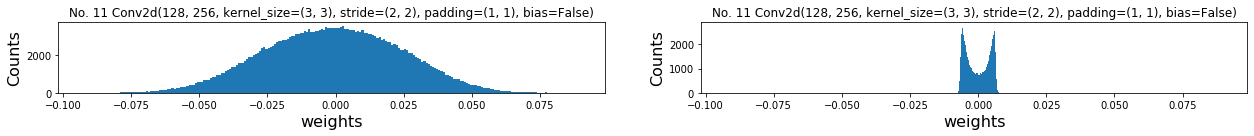

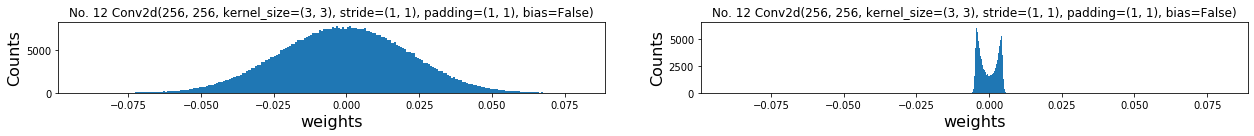

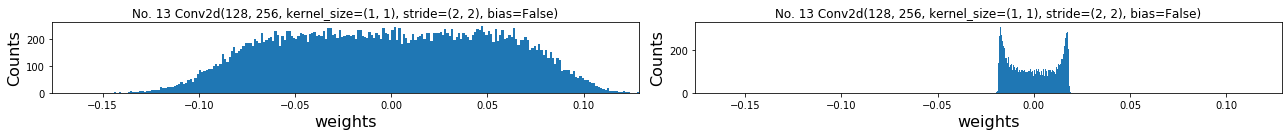

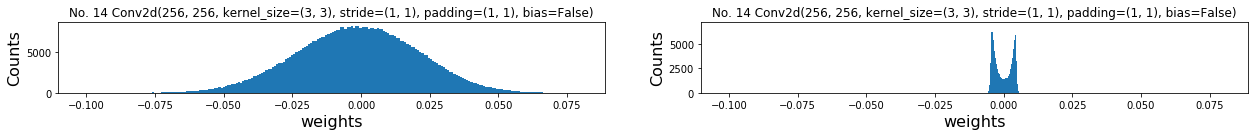

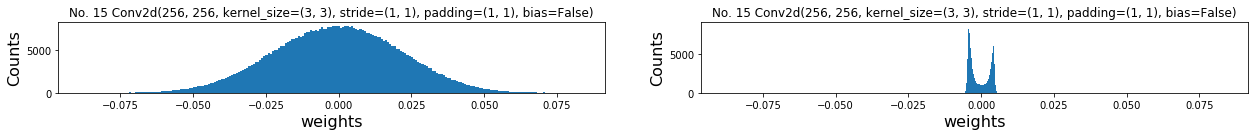

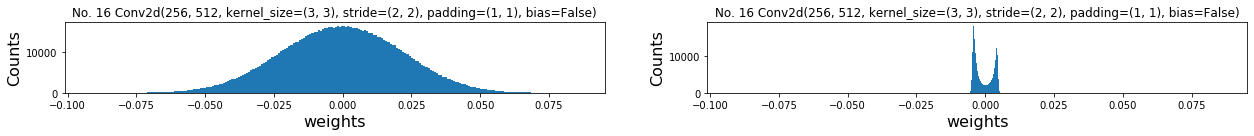

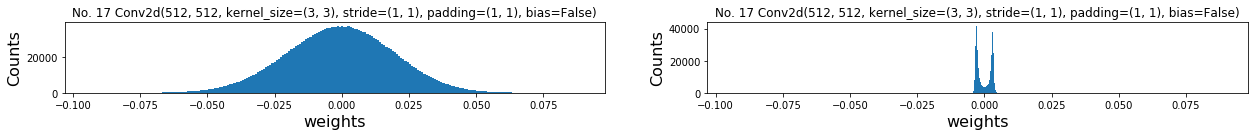

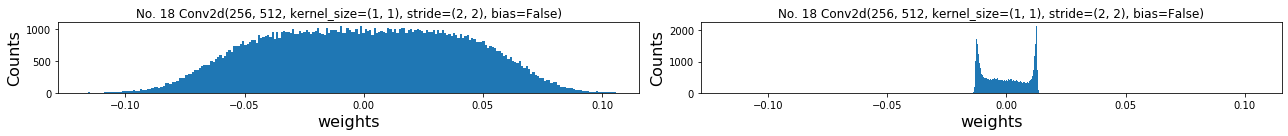

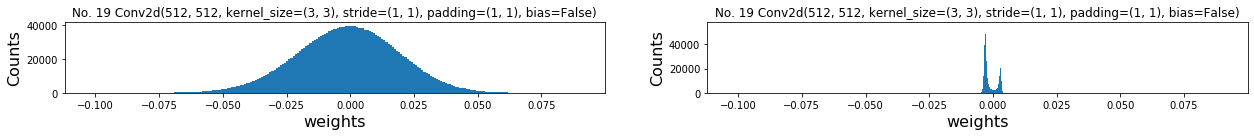

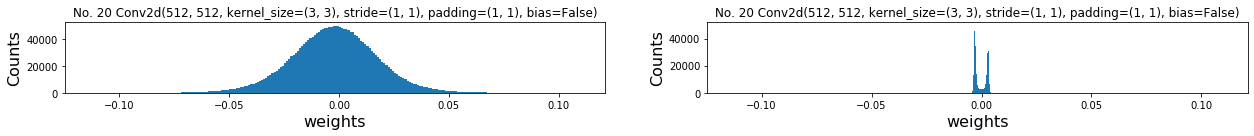

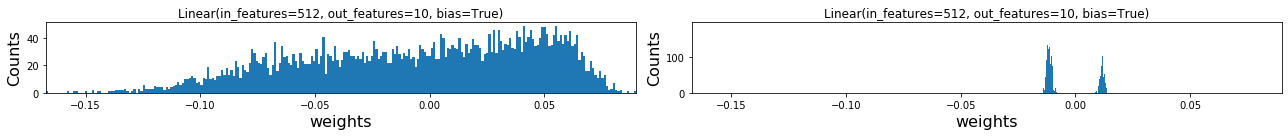

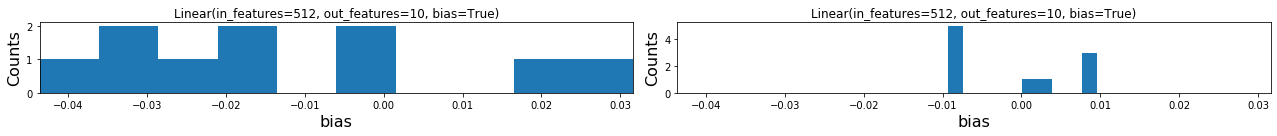

In [23]:
plot_ResNet18_dist("nr0_4novol.pt", "nr0_4v0_2a0_99.pt", name="nr04-")

/Users/zihao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/zihao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


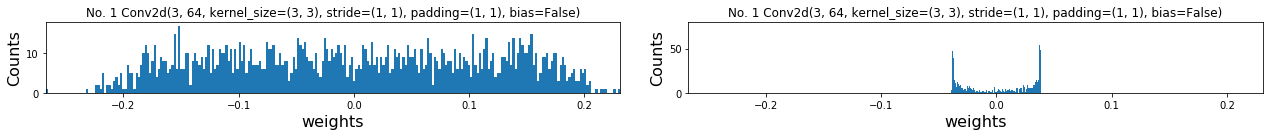

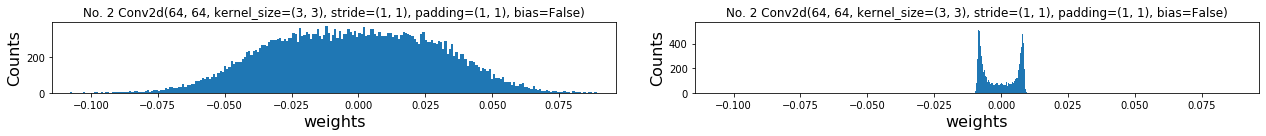

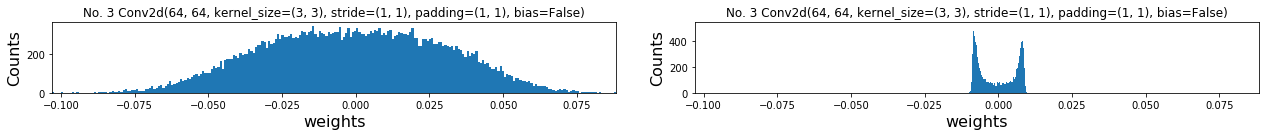

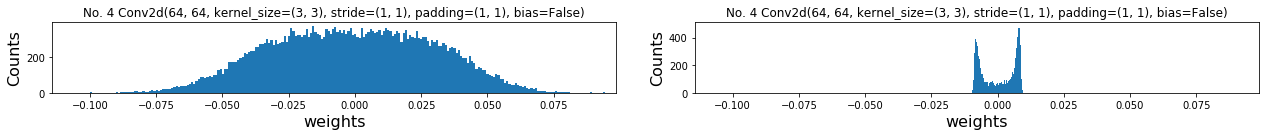

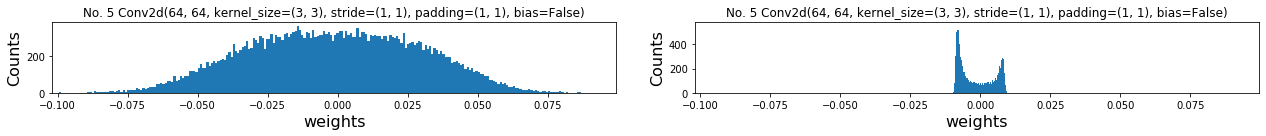

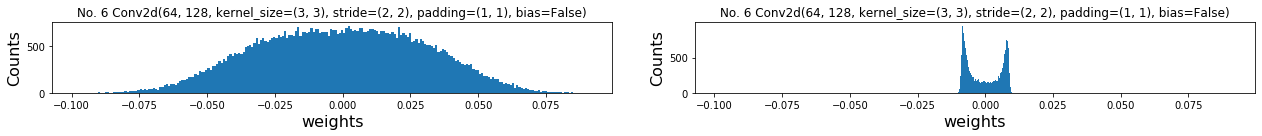

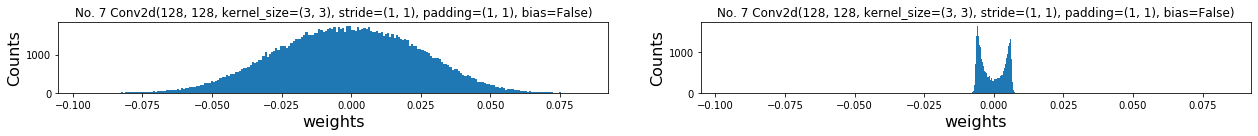

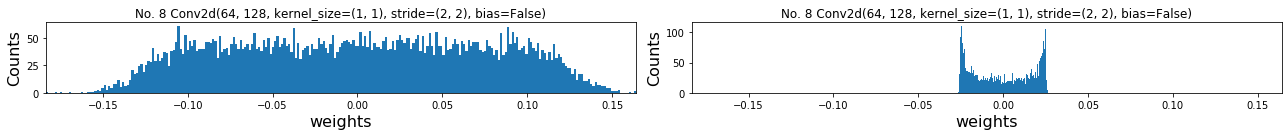

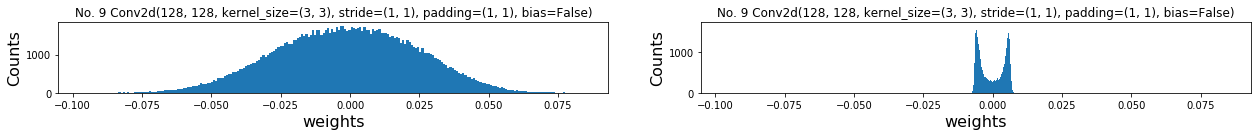

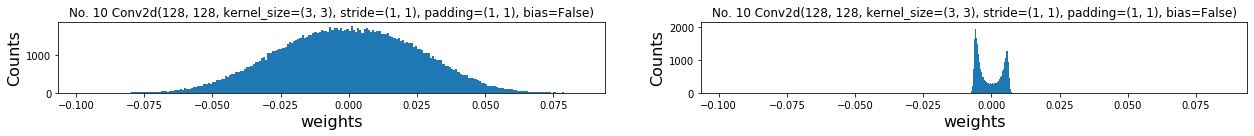

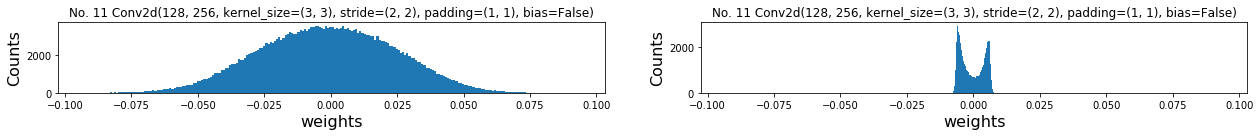

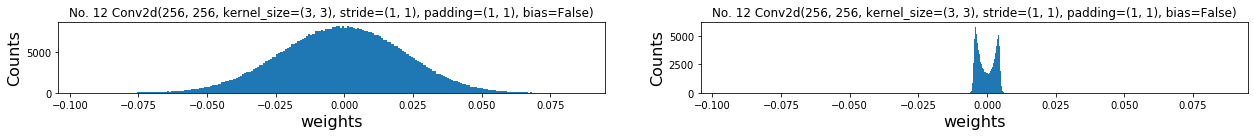

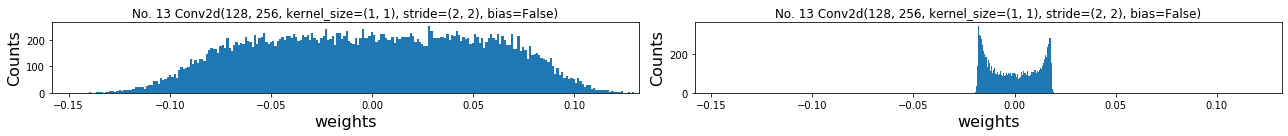

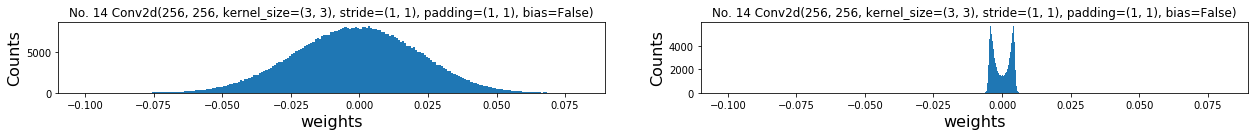

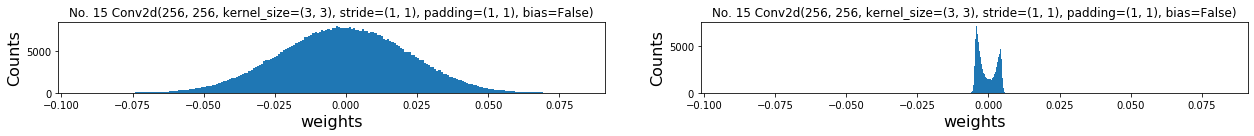

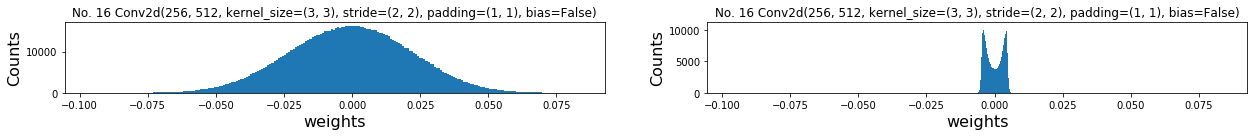

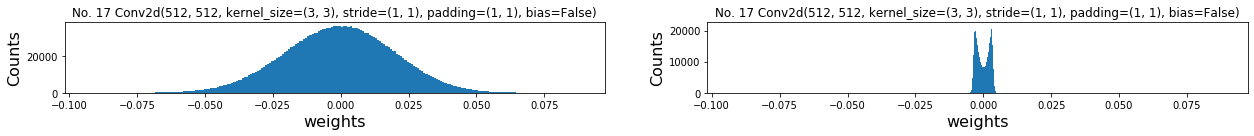

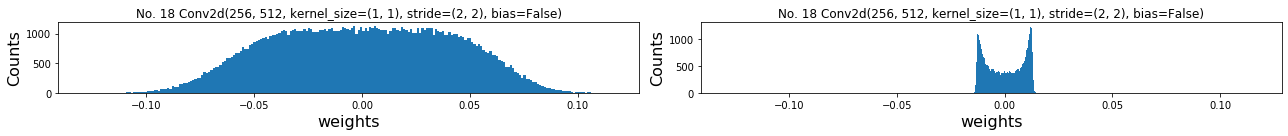

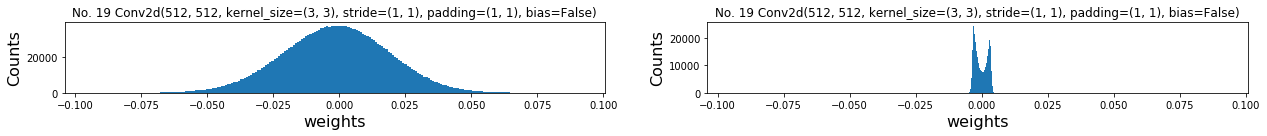

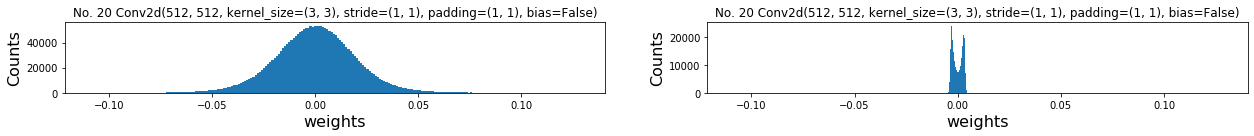

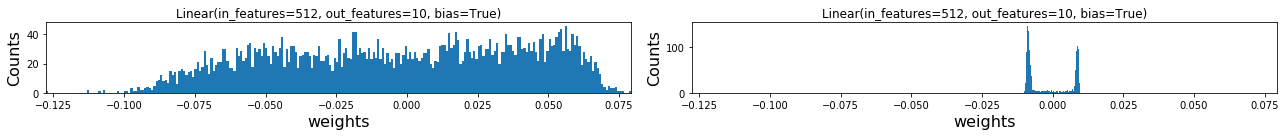

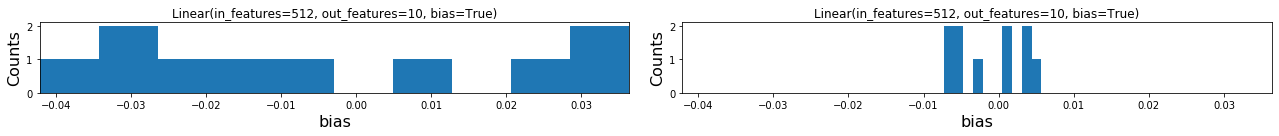

In [24]:
plot_ResNet18_dist("nr0_8novol.pt", "nr0_8v0_2a0_99.pt", name="nr08-")